# 🦠 COVID-19 USA New Cases Prediction  
In this notebook, we predict daily new COVID-19 cases in the USA using historical case trends, vaccination data, and testing numbers.


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("owid-covid-data.csv")

print("Shape of dataset:", df.shape)
print("\nFirst 5 rows:\n", df.head())

print("\nColumns in dataset:\n", df.columns.tolist())

print("\nMissing values per column:\n", df.isnull().sum())

print("\nUnique locations:", df['location'].nunique())
print("Sample locations:", df['location'].unique()[:15])

excluded = ['World', 'Africa', 'Asia', 'Europe', 'European Union', 
            'North America', 'Oceania', 'South America', 'International']
df_countries = df[~df['location'].isin(excluded)]

print("\nShape after keeping only countries:", df_countries.shape)


Shape of dataset: (350085, 67)

First 5 rows:
   iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-01-03          NaN        0.0   
1      AFG      Asia  Afghanistan  2020-01-04          NaN        0.0   
2      AFG      Asia  Afghanistan  2020-01-05          NaN        0.0   
3      AFG      Asia  Afghanistan  2020-01-06          NaN        0.0   
4      AFG      Asia  Afghanistan  2020-01-07          NaN        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         0.0                  NaN  ...   
1                 NaN           NaN         0.0                  NaN  ...   
2                 NaN           NaN         0.0                  NaN  ...   
3                 NaN           NaN         0.0                  NaN  ...   
4                 NaN           NaN         0.0                  NaN  ...   

   male_smokers  handwashing_facilities  hospital_b

## 📂 Step 1: Load and Inspect Dataset
We start by loading the OWID COVID-19 dataset and inspecting its structure.


In [ ]:
# Feature selection & preprocessing

drop_cols = ['iso_code', 'continent']
df_countries = df_countries.drop(columns=drop_cols, errors='ignore')

df_countries['date'] = pd.to_datetime(df_countries['date'])

df_countries['year'] = df_countries['date'].dt.year
df_countries['month'] = df_countries['date'].dt.month

missing_percent = (df_countries.isnull().sum() / len(df_countries)) * 100
print("\nMissing values percentage per column:\n", missing_percent)

num_cols = df_countries.select_dtypes(include=['float64', 'int64']).columns
df_countries[num_cols] = df_countries[num_cols].fillna(df_countries[num_cols].median())

print("\nMissing values after filling:\n", df_countries.isnull().sum().sum())

print("\nCleaned dataset preview:\n", df_countries.head())



Missing values percentage per column:
 location                                    0.000000
date                                        0.000000
total_cases                                11.158640
new_cases                                   2.831477
new_cases_smoothed                          3.191091
                                             ...    
excess_mortality_cumulative                96.405635
excess_mortality                           96.405635
excess_mortality_cumulative_per_million    96.405635
year                                        0.000000
month                                       0.000000
Length: 67, dtype: float64

Missing values after filling:
 232187

Cleaned dataset preview:
       location       date  total_cases  new_cases  new_cases_smoothed  \
0  Afghanistan 2020-01-03      63174.5        0.0              20.857   
1  Afghanistan 2020-01-04      63174.5        0.0              20.857   
2  Afghanistan 2020-01-05      63174.5        0.0              20

## 📊 Step 2: Exploratory Data Analysis (EDA)
We will check missing values, visualize trends, and explore feature correlations.


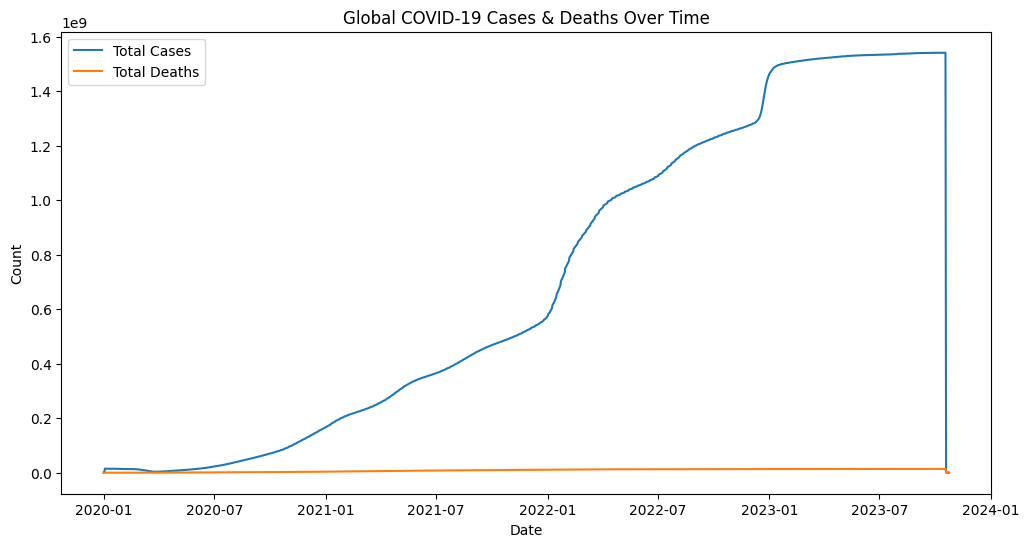

C:\Users\DANISH LAPTOP\AppData\Local\Temp\ipykernel_2808\1256482024.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_cases', y='location', data=top_cases, palette='Reds_r')


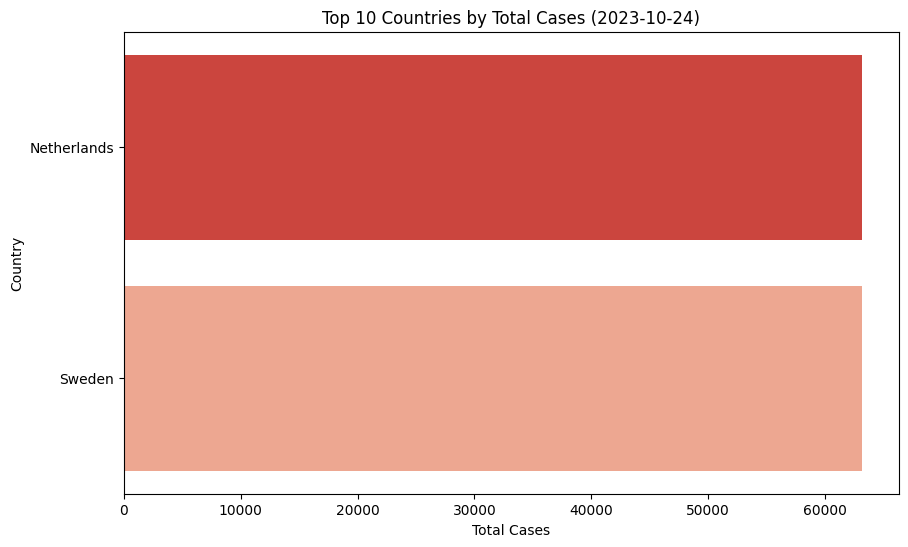

C:\Users\DANISH LAPTOP\AppData\Local\Temp\ipykernel_2808\1256482024.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_deaths', y='location', data=top_deaths, palette='Greys_r')


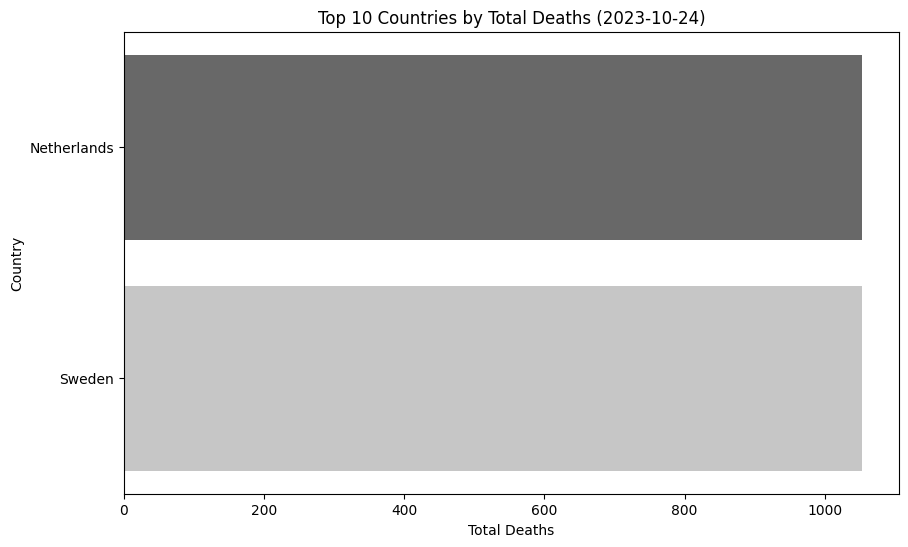

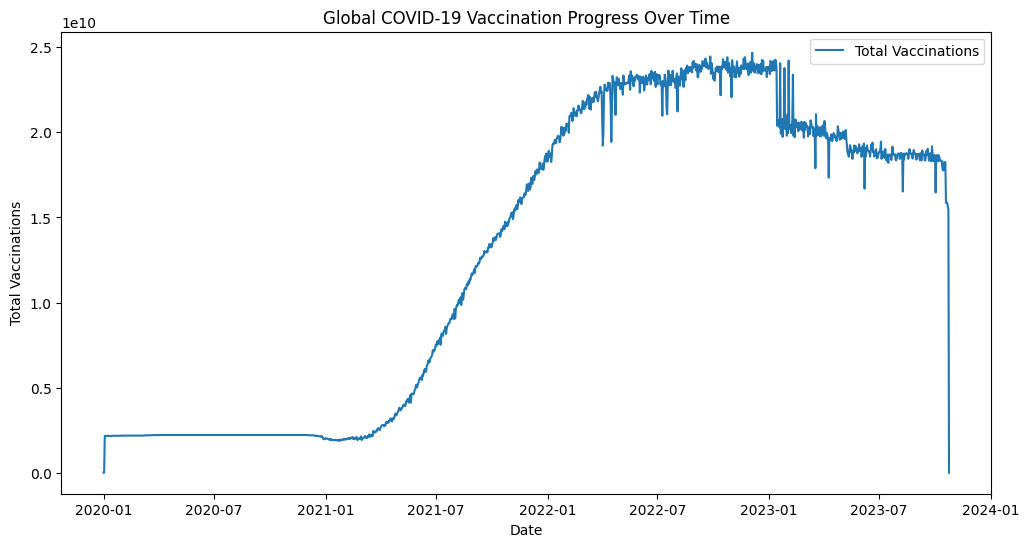

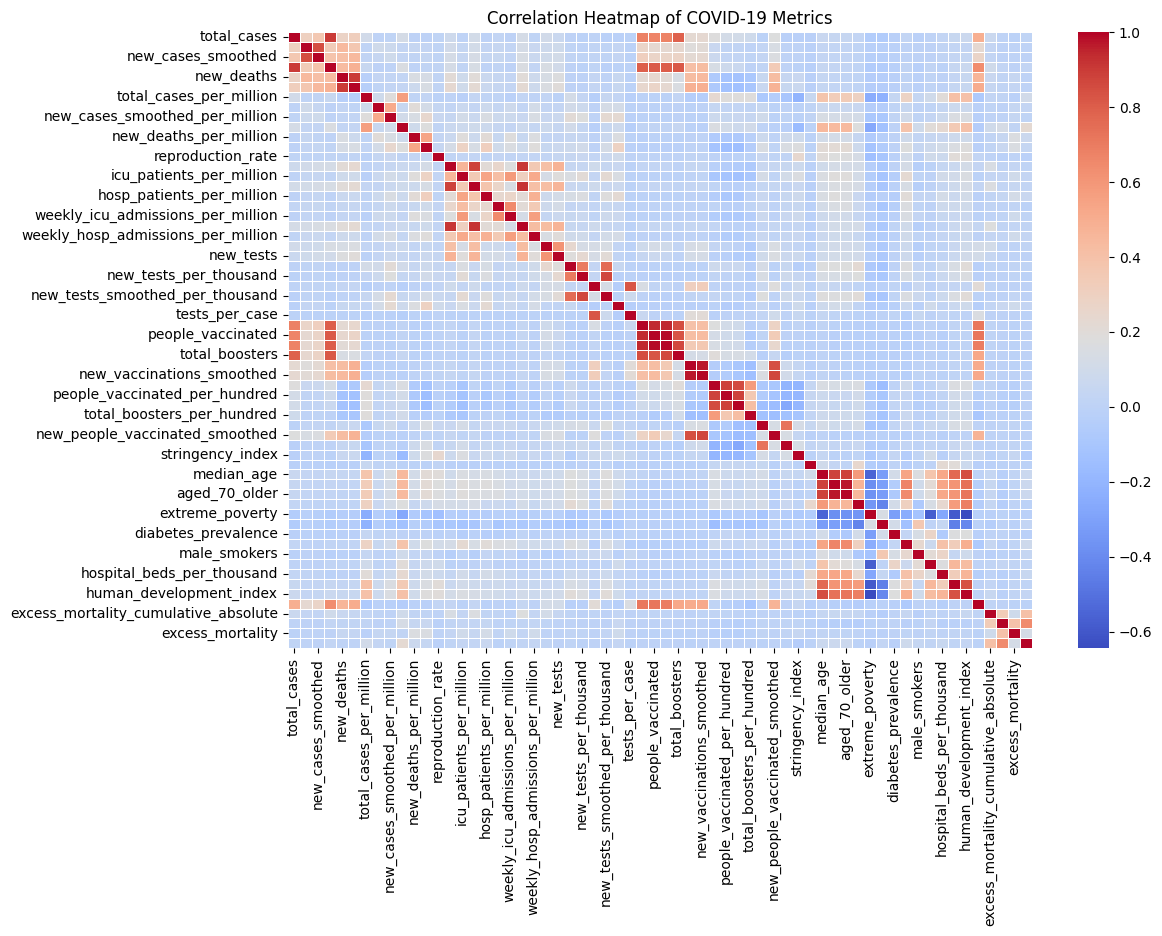

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exploratory Data Analysis (EDA)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_countries.groupby('date')['total_cases'].sum(), label='Total Cases')
sns.lineplot(data=df_countries.groupby('date')['total_deaths'].sum(), label='Total Deaths')
plt.title('Global COVID-19 Cases & Deaths Over Time')
plt.ylabel('Count')
plt.xlabel('Date')
plt.legend()
plt.show()

latest_date = df_countries['date'].max()
top_cases = df_countries[df_countries['date'] == latest_date].nlargest(10, 'total_cases')
plt.figure(figsize=(10, 6))
sns.barplot(x='total_cases', y='location', data=top_cases, palette='Reds_r')
plt.title(f'Top 10 Countries by Total Cases ({latest_date.date()})')
plt.xlabel('Total Cases')
plt.ylabel('Country')
plt.show()

top_deaths = df_countries[df_countries['date'] == latest_date].nlargest(10, 'total_deaths')
plt.figure(figsize=(10, 6))
sns.barplot(x='total_deaths', y='location', data=top_deaths, palette='Greys_r')
plt.title(f'Top 10 Countries by Total Deaths ({latest_date.date()})')
plt.xlabel('Total Deaths')
plt.ylabel('Country')
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_countries.groupby('date')['total_vaccinations'].sum(), label='Total Vaccinations')
plt.title('Global COVID-19 Vaccination Progress Over Time')
plt.ylabel('Total Vaccinations')
plt.xlabel('Date')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
corr = df_countries.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of COVID-19 Metrics')
plt.show()


## 🧠 Step 4: Model Training – Baseline Random Forest
We start with a baseline Random Forest Regressor using current-day features only.


Random Forest Model Performance for USA New Cases Prediction:
RMSE: 52121.43
R² Score: -0.1633


C:\Users\DANISH LAPTOP\AppData\Local\Temp\ipykernel_2808\726176042.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_importance_df, palette='viridis')


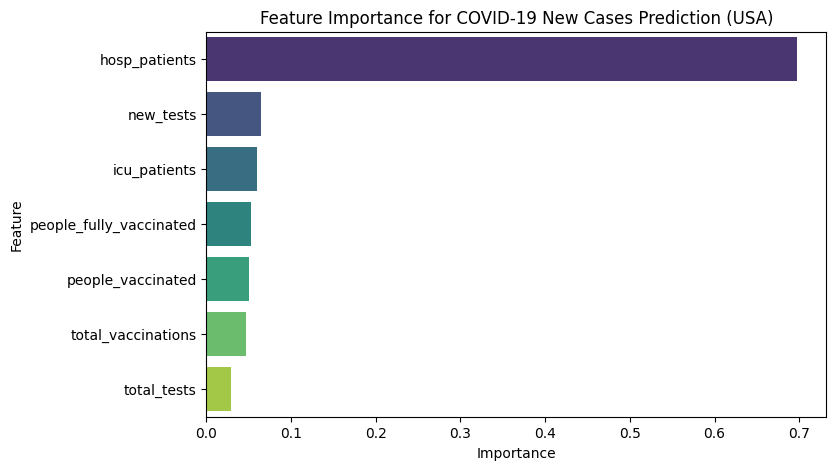

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predictive Modeling

country_df = df_countries[df_countries['location'] == 'United States'].copy()

features = ['new_tests', 'total_tests', 'total_vaccinations', 
            'people_vaccinated', 'people_fully_vaccinated', 
            'hosp_patients', 'icu_patients']
target = 'new_cases'

country_df = country_df.dropna(subset=features + [target])

X = country_df[features]
y = country_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Random Forest Model Performance for USA New Cases Prediction:")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

importances = rf_model.feature_importances_
feat_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df, palette='viridis')
plt.title('Feature Importance for COVID-19 New Cases Prediction (USA)')
plt.show()


## 📈 Step 5: Model Improvement with Lag Features
We add lag features (previous day and previous week) to improve prediction accuracy.


C:\Users\DANISH LAPTOP\AppData\Local\Temp\ipykernel_2808\4113453040.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_usa = df_usa.fillna(method='ffill').fillna(0)


Improved RMSE: 32096.95
Improved R²: 0.5619


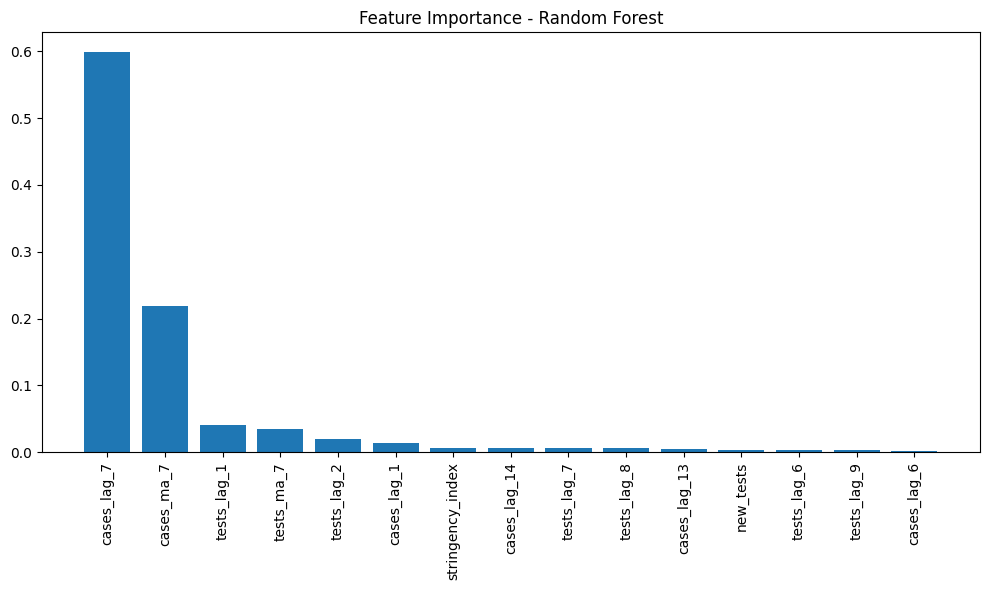

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

df = pd.read_csv("owid-covid-data.csv")

df_usa = df[df['location'] == 'United States'].copy()

df_usa = df_usa[['date', 'new_cases', 'new_tests', 'stringency_index']]

df_usa['date'] = pd.to_datetime(df_usa['date'])

df_usa = df_usa.fillna(method='ffill').fillna(0)

for lag in range(1, 15):
    df_usa[f'cases_lag_{lag}'] = df_usa['new_cases'].shift(lag)
    df_usa[f'tests_lag_{lag}'] = df_usa['new_tests'].shift(lag)

df_usa['cases_ma_7'] = df_usa['new_cases'].rolling(window=7).mean()
df_usa['cases_ma_14'] = df_usa['new_cases'].rolling(window=14).mean()
df_usa['tests_ma_7'] = df_usa['new_tests'].rolling(window=7).mean()

df_usa.dropna(inplace=True)

X = df_usa.drop(columns=['date', 'new_cases'])
y = df_usa['new_cases']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Improved RMSE: {rmse:.2f}")
print(f"Improved R²: {r2:.4f}")


importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importance - Random Forest")
plt.bar(range(15), importances[indices][:15], align="center")
plt.xticks(range(15), [X.columns[i] for i in indices][:15], rotation=90)
plt.tight_layout()
plt.show()


## 📊 Step 6: Model Comparison
We compare RMSE and R² scores between the baseline and improved models.


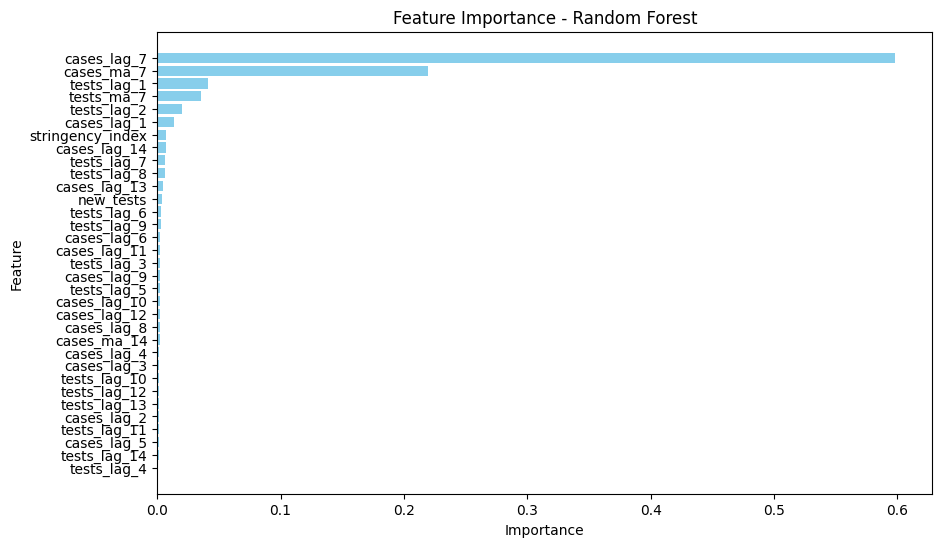

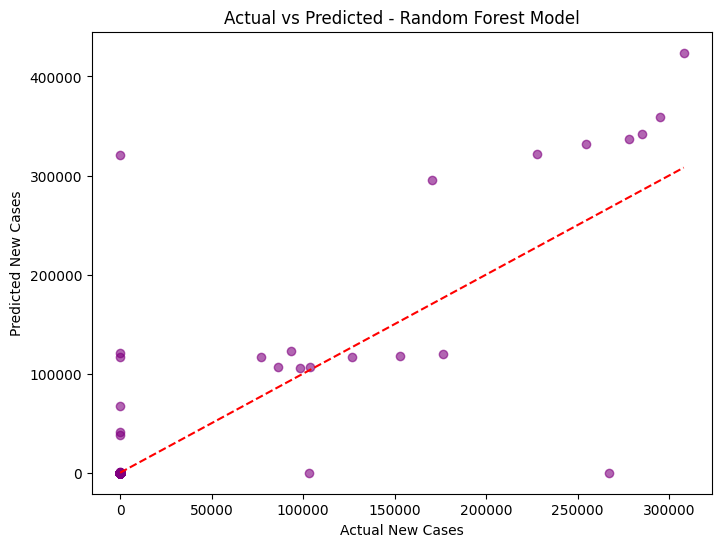

Top 10 Features:
              Feature  Importance
14       cases_lag_7    0.598444
30        cases_ma_7    0.219390
3        tests_lag_1    0.041076
32        tests_ma_7    0.035192
5        tests_lag_2    0.020415
2        cases_lag_1    0.013272
1   stringency_index    0.006829
28      cases_lag_14    0.006706
15       tests_lag_7    0.006305
17       tests_lag_8    0.005913


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

importances = rf.feature_importances_
feature_names = X.columns
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Random Forest')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         '--', color='red')
plt.xlabel('Actual New Cases')
plt.ylabel('Predicted New Cases')
plt.title('Actual vs Predicted - Random Forest Model')
plt.show()

print("Top 10 Features:\n", feature_df.head(10))


## 🏁 Step 7: Conclusion
- Lag features greatly improve model performance.
- Vaccination and testing data contribute but historical case trends dominate predictions.
- Next step: Try time-series models like ARIMA, Prophet, or LSTM.
